In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [2]:
#load the processed split data
def load_df(name):
    return pd.read_pickle('data/'+name+'.pkl')

[x_train, y_train, x_test, y_test, x_val, y_val] = map(load_df, ['x_train','y_train','x_test','y_test', 'x_val','y_val']) 

In [6]:
#clf = make_pipeline(StandardScaler(),SVC(gamma='auto'))
clf = SVC(gamma='auto',kernel='linear')
clf.fit(x_train,y_train['sample_collection_site'])
val_score = clf.score(x_val,y_val['sample_collection_site'])
print('this is the validation score : ',val_score)

this is the validation score :  0.5285714285714286


In [5]:
y_pred = clf.predict(x_test)
y = y_test['sample_collection_site']
print(accuracy_score(y, y_pred))
print(f1_score(y, y_pred, average="macro"))
print(precision_score(y, y_pred, average="macro"))
print(recall_score(y, y_pred, average="macro"))

0.44285714285714284
0.3913263387044347
0.4516595179452385
0.3942126263882746


c:\Users\boop\anaconda3\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
#validation loop for finding the optimal maximum tree depth for using a random forrest classifier (RF) to classify the data
accs = []
for i in tqdm(range(1,30)):
    rf_classifier = RandomForestClassifier(max_depth=i, random_state=0, n_jobs=8, n_estimators=250)
    rf_classifier.fit(x_train,y_train['sample_collection_site'])
    y_pred = rf_classifier.predict(x_val)
    accs.append(accuracy_score(y_val['sample_collection_site'], y_pred))

100%|██████████| 29/29 [01:51<00:00,  3.84s/it]


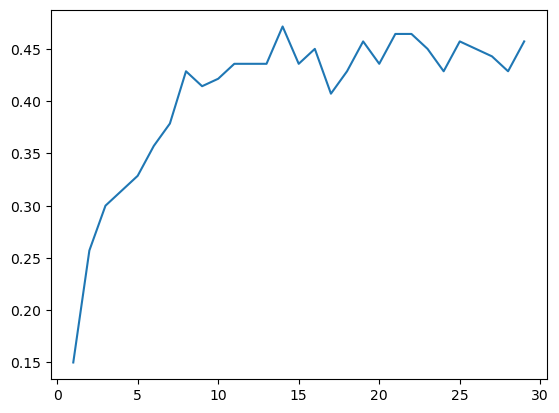

In [18]:
plt.plot(list(range(1,30)), accs)
plt.show()

In [76]:
#checking effect of number of principal components for training RF in a kernel PCA with Linear basis
accs_pca = []
#arbitrary choice of using 64 up to the number of samples jumping by 50
for j in tqdm(range(64,x_train.shape[0],50)):
    #creating the kernel PCA model
    kpca = KernelPCA(n_components=j, kernel='linear', n_jobs=8)
    #train and get the top j PCs
    x_train_comps =  kpca.fit_transform(x_train)
    #define RF model
    rf_classifier = RandomForestClassifier(max_depth=15, random_state=0, n_jobs=8)
    #train classifier with the PCs
    rf_classifier.fit(x_train_comps,y_train['sample_collection_site'])
    #use validation set to measure accuracy of classification
    y_pred = rf_classifier.predict(kpca.transform(x_val))
    accs_pca.append(accuracy_score(y_val['sample_collection_site'], y_pred))

100%|██████████| 22/22 [00:28<00:00,  1.31s/it]


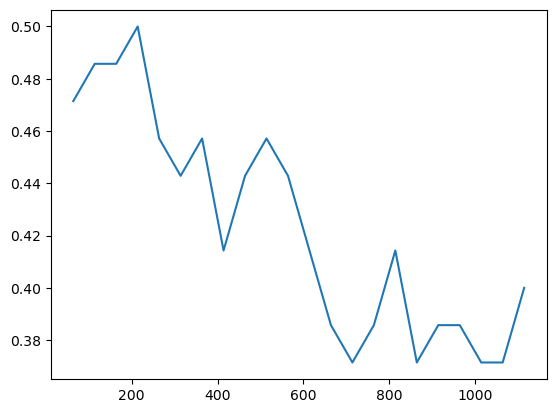

In [77]:
#plotting accuracy (y-axis) against number of PCs (x-axis)
plt.plot(list(range(64,1125,50)), accs_pca)
plt.show()

In [92]:
#checking effect of number of principal components for training RF in a kernel PCA with Cosine basis
accs_cos_pca = []
#arbitrary choice of using 64 up to the number of samples jumping by 50
for j in tqdm(range(64,x_train.shape[0],50)):
    #creating the kernel PCA model
    kpca = KernelPCA(n_components=j, kernel='linear', n_jobs=8)
    #train and get the top j PCs
    x_train_comps =  kpca.fit_transform(x_train)
    #define RF model
    rf_classifier = RandomForestClassifier(max_depth=15, random_state=0, n_jobs=8)
    #train classifier with the PCs
    rf_classifier.fit(x_train_comps,y_train['sample_collection_site'])
    #use validation set to measure accuracy of classification
    y_pred = rf_classifier.predict(kpca.transform(x_val))
    accs_cos_pca.append(accuracy_score(y_val['sample_collection_site'], y_pred))

100%|██████████| 22/22 [00:35<00:00,  1.59s/it]


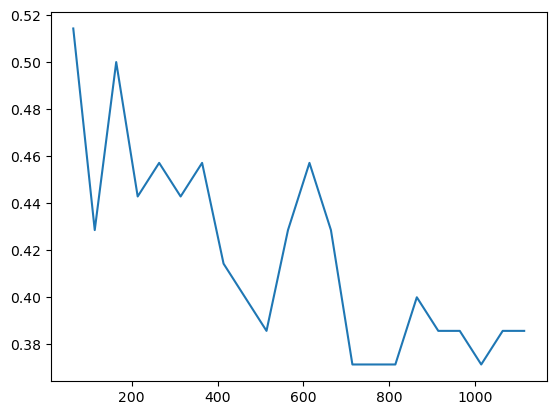

In [93]:
#plotting accuracy (y-axis) against number of PCs (x-axis)
plt.plot(list(range(64,1125,50)), accs_cos_pca)
plt.show()

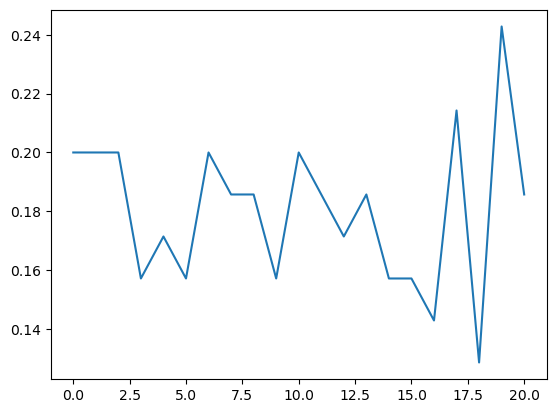

In [91]:
#validation for sigmoid kernel
plt.plot(accs_rbf_pca)
plt.show()

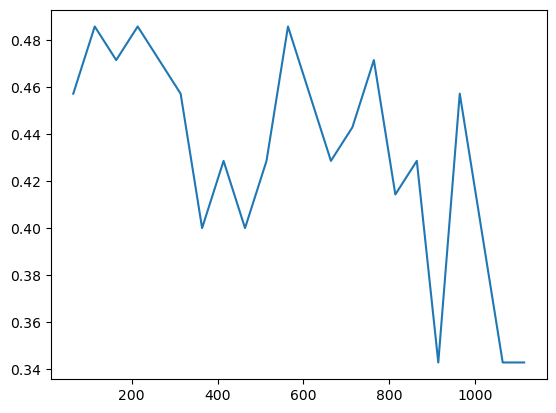

In [88]:
#validation for polynomial kernel
plt.plot(list(range(64,1125,50)), accs_rbf_pca)
plt.show()

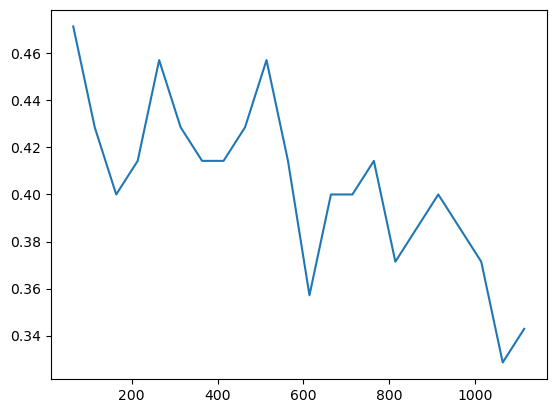

In [86]:
#validation trace for RBF kernel
plt.plot(list(range(64,1125,50)), accs_rbf_pca)
plt.show()

In [13]:
#validation loop to check both max depth of of trees in the RF and the PCs used for the classification
accs_2par = np.zeros(len(list(range(64,x_train.shape[0],50)))*19).reshape(19,len(list(range(64,x_train.shape[0],50))))
max_score = 0
params = (0,0)
for i in tqdm(range(1,20)):
    for idx, j in enumerate(range(64,x_train.shape[0],50)):
        kpca = KernelPCA(n_components=j, kernel='cosine', n_jobs=8)
        x_train_comps =  kpca.fit_transform(x_train)
        rf_classifier = RandomForestClassifier(max_depth=i, random_state=0, n_jobs=8)
        rf_classifier.fit(x_train_comps,y_train['sample_collection_site'])
        y_pred = rf_classifier.predict(kpca.transform(x_val))
        acc = accuracy_score(y_val['sample_collection_site'], y_pred)
        if acc > max_score:
            max_score = acc
            params = (i,j)
        accs_2par[i,idx] = acc

 95%|█████████▍| 18/19 [08:47<00:29, 29.28s/it]


IndexError: index 19 is out of bounds for axis 0 with size 19

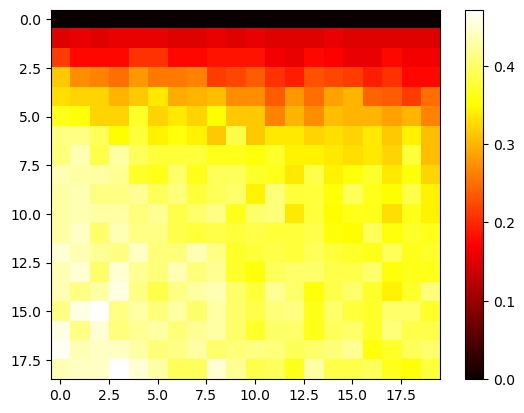

In [14]:
plt.imshow(accs_2par, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [15]:
#find params for the best accuracy
print(max_score)
params

0.4714285714285714


(15, 164)

In [7]:
list(range(64,x_train.shape[0],50))[18]

964

In [16]:
#using the test set to get a baseline prediction accuracy and f1 score

kpca = KernelPCA(n_components=164, kernel='linear', n_jobs=8)
x_train_comps =  kpca.fit_transform(x_train)

rf_classifier = RandomForestClassifier(max_depth=15, random_state=0, n_jobs=8)
rf_classifier.fit(x_train_comps,y_train['sample_collection_site'])
y_pred = rf_classifier.predict(kpca.transform(x_test))

print('accuracy:', accuracy_score(y_test['sample_collection_site'], y_pred))
print('f1 score:',f1_score(y_test['sample_collection_site'], y_pred, average="macro"))
print('precision:',precision_score(y_test['sample_collection_site'], y_pred, average="macro"))
print('recall:',recall_score(y_test['sample_collection_site'], y_pred, average="macro"))

accuracy: 0.3904761904761905
f1 score: 0.27536031565114893
precision: 0.3048988509877635
recall: 0.3005432968143398


c:\Users\boop\anaconda3\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4 IS THE BASELINE ACCURACY TO BEAT WITH |
Seems its more about how deep the classifier is and the dimension reduction doesn't necessarily improve accuracy|
but seems like its better when we look at less features so the top PCs|
Seems SVC works best